I have just discovered that there's another method of dealing with imbalanced data. A lot of the models in sklearn has "class_weight" parameter that change the penalties associated with different label values. Let's give it a try (as well as fine-tuning the model).

Import data and apply the same preprocessing as in exploration_2.ipynb and exploration_3.ipynb

In [37]:
import pandas as pd
import dill
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler

In [38]:
data = pd.read_csv('../data/heart_2020_cleaned.csv')

In [39]:
# ordinal encoding for AgeCategory, GenHealth, Diabetic columns
data['AgeCategory'] = data['AgeCategory'].replace({'55-59':7, '80 or older':12, '65-69':9, '75-79':11, '40-44':4, '70-74':10,
                '60-64':8, '50-54':6, '45-49':5, '18-24':0, '35-39':3, '30-34':2, '25-29':1})
data['GenHealth'] = data['GenHealth'].replace({'Excellent': 0, 'Very good': 1, 'Good': 2, 'Fair': 3, 'Poor': 4})
data['Diabetic'] = data['Diabetic'].replace({'Yes':2, 'No, borderline diabetes':1, 'Yes (during pregnancy)':0, 'No':0})

# one-hot encoding for the rest of the categorical columns
category_cols = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data=data, columns=category_cols, drop_first=True)
print(data.columns)
print(data)

X = data.drop('HeartDisease_Yes', axis=1)
y = data['HeartDisease_Yes']

print(X.shape, y.shape)

std_scaler = StandardScaler()
X = std_scaler.fit_transform(X)
# save the scaler
dill.dump(std_scaler, open('../models/std_scaler.pkl', 'wb'))

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'AgeCategory', 'Diabetic',
       'GenHealth', 'SleepTime', 'HeartDisease_Yes', 'Smoking_Yes',
       'AlcoholDrinking_Yes', 'Stroke_Yes', 'DiffWalking_Yes', 'Sex_Male',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'PhysicalActivity_Yes', 'Asthma_Yes', 'KidneyDisease_Yes',
       'SkinCancer_Yes'],
      dtype='object')
          BMI  PhysicalHealth  MentalHealth  AgeCategory  Diabetic  GenHealth  \
0       16.60               3            30            7         2          1   
1       20.34               0             0           12         0          1   
2       26.58              20            30            9         2          3   
3       24.21               0             0           11         0          2   
4       23.71              28             0            4         0          1   
...       ...             ...           ...          ...       ...        ...   
319790  27.41        

In [20]:
counts = y_train.value_counts()
print(counts)
scale_pos_weight = counts[0] / counts[1]

0    234055
1     21781
Name: HeartDisease_Yes, dtype: int64


A quick logistic regression to see how it performs

In [40]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.75      0.85     58367
           1       0.23      0.78      0.35      5592

    accuracy                           0.75     63959
   macro avg       0.60      0.76      0.60     63959
weighted avg       0.91      0.75      0.80     63959



Let's fine tune XGBClassifier.

The score we will use here is the F1 score because ROC_AUC score does not get affected by the imbalance of the data as much as F1 score. We fine tune the parameters scale_pos_weight, max_depth, and min_child_weight first because they have the most impact on the model.

In [98]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

params = {'scale_pos_weight': [scale_pos_weight, 1, 100], 'max_depth': [3, 5, 10], 'min_child_weight': [1, 3, 6]}
xgb_grid = GridSearchCV(XGBClassifier(), params, cv=5, scoring=scoring, refit='f1', verbose=2)

In [100]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1.0; total time=   4.4s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1.0; total time=   4.3s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1.0; total time=   4.9s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1.0; total time=   4.7s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1.0; total time=   4.9s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1; total time=   4.6s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1; total time=   4.6s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1; total time=   4.5s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1; total time=   4.6s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=1; total time=   4.6s
[CV] END max_depth=3, min_child_weight=1, scale_pos_weight=100; total time=   4.8s
[CV] END max_depth=3, min_child_wei

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'max_depth': [3, 5, 10], 'min_child_weight': [1, 3, 6],
                         'scale_pos_weight': [1.0, 1, 100]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

Text(0.5, 1.0, 'Feature Importance')

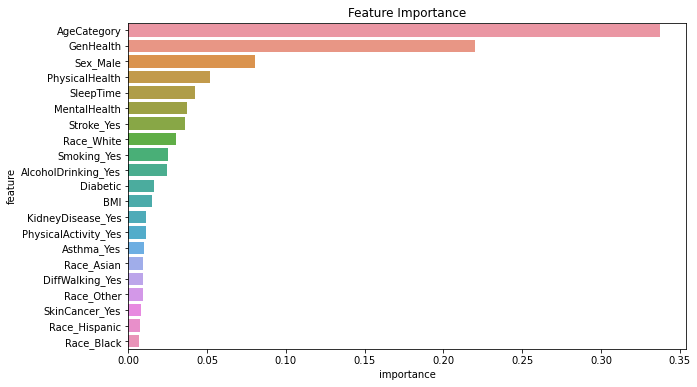

In [112]:
# feature importance
xgb = xgb_grid.best_estimator_
feature_importance = pd.DataFrame({'feature': data.drop(['HeartDisease_Yes'], axis=1).columns, 'importance': xgb.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')

In [105]:
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)
xgb_grid_result_data = pd.DataFrame(xgb_grid.cv_results_)
print(xgb_grid_result_data.loc[xgb_grid.best_index_, ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']])
optimal_scale_pos_weight = xgb_grid.best_params_['scale_pos_weight']
optimal_max_depth = xgb_grid.best_params_['max_depth']
optimal_min_child_weight = xgb_grid.best_params_['min_child_weight']

{'max_depth': 10, 'min_child_weight': 1, 'scale_pos_weight': 1.0}
0.9152479035813501
mean_test_accuracy     0.928414
mean_test_precision    0.964718
mean_test_recall       0.890927
mean_test_f1           0.915248
mean_test_roc_auc      0.972624
Name: 18, dtype: object


Now let's fine tune the parameter gamma

In [106]:
xgb_grid2 = GridSearchCV(
    XGBClassifier(scale_pos_weight=optimal_scale_pos_weight, max_depth=optimal_max_depth, min_child_weight=optimal_min_child_weight),
    {'gamma': [i / 10 for i in range(10)]},
    cv=5,
    scoring=scoring,
    refit='f1',
    verbose=2
)

xgb_grid2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..........................................gamma=0.0; total time=  16.9s
[CV] END ..........................................gamma=0.0; total time=  16.5s
[CV] END ..........................................gamma=0.0; total time=  17.4s
[CV] END ..........................................gamma=0.0; total time=  16.8s
[CV] END ..........................................gamma=0.0; total time=  17.7s
[CV] END ..........................................gamma=0.1; total time=  18.9s
[CV] END ..........................................gamma=0.1; total time=  20.1s
[CV] END ..........................................gamma=0.1; total time=  19.2s
[CV] END ..........................................gamma=0.1; total time=  18.9s
[CV] END ..........................................gamma=0.1; total time=  20.4s
[CV] END ..........................................gamma=0.2; total time=  26.4s
[CV] END .......................................

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=10,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [108]:
print(xgb_grid2.best_params_)
print(xgb_grid2.best_score_)
xgb_grid_result_data2 = pd.DataFrame(xgb_grid2.cv_results_)
print(xgb_grid_result_data2.loc[xgb_grid2.best_index_, ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']])
optimal_gamma = xgb_grid2.best_params_['gamma']

{'gamma': 0.7}
0.915785664820002
mean_test_accuracy     0.928914
mean_test_precision    0.965116
mean_test_recall       0.891278
mean_test_f1           0.915786
mean_test_roc_auc      0.972398
Name: 7, dtype: object


Next, fine-tune parameters subsample and colsample_bytree.

In [110]:
xgb_grid3 = GridSearchCV(
    XGBClassifier(scale_pos_weight=optimal_scale_pos_weight, max_depth=optimal_max_depth, min_child_weight=optimal_min_child_weight, gamma=optimal_gamma),
    {'subsample': [i / 10 for i in range(5, 10)], 'colsample_bytree': [i / 10 for i in range(5, 10)]},
    cv=5,
    scoring=scoring,
    refit='f1',
    verbose=2
)

xgb_grid3.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ................colsample_bytree=0.5, subsample=0.5; total time=  12.3s
[CV] END ................colsample_bytree=0.5, subsample=0.5; total time=  12.6s
[CV] END ................colsample_bytree=0.5, subsample=0.5; total time=  12.4s
[CV] END ................colsample_bytree=0.5, subsample=0.5; total time=  12.6s
[CV] END ................colsample_bytree=0.5, subsample=0.5; total time=  12.9s
[CV] END ................colsample_bytree=0.5, subsample=0.6; total time=  13.5s
[CV] END ................colsample_bytree=0.5, subsample=0.6; total time=  13.5s
[CV] END ................colsample_bytree=0.5, subsample=0.6; total time=  13.4s
[CV] END ................colsample_bytree=0.5, subsample=0.6; total time=  13.2s
[CV] END ................colsample_bytree=0.5, subsample=0.6; total time=  13.2s
[CV] END ................colsample_bytree=0.5, subsample=0.7; total time=  12.5s
[CV] END ................colsample_bytree=0.5, 

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0.7, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat...
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [111]:
print(xgb_grid3.best_params_)
print(xgb_grid3.best_score_)
xgb_grid_result_data3 = pd.DataFrame(xgb_grid3.cv_results_)
print(xgb_grid_result_data3.loc[xgb_grid3.best_index_, ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']])
optimal_subsample = xgb_grid3.best_params_['subsample']
optimal_colsample_bytree = xgb_grid3.best_params_['colsample_bytree']

{'colsample_bytree': 0.9, 'subsample': 0.9}
0.9154765147522067
mean_test_accuracy      0.92869
mean_test_precision    0.965271
mean_test_recall       0.890731
mean_test_f1           0.915477
mean_test_roc_auc      0.972351
Name: 24, dtype: object


Next, fine-tune parameters reg_alpha.

In [16]:
xgb_grid4 = GridSearchCV(
    XGBClassifier(scale_pos_weight=optimal_scale_pos_weight, max_depth=optimal_max_depth, min_child_weight=optimal_min_child_weight, gamma=optimal_gamma, subsample=optimal_subsample, colsample_bytree=optimal_colsample_bytree),
    {'reg_alpha': [0, 0.0001, 0.01, 1, 100]},
    cv=5,
    scoring=scoring,
    refit='f1',
    verbose=2
)

xgb_grid4.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................reg_alpha=0; total time=   3.0s
[CV] END ........................................reg_alpha=0; total time=   2.9s
[CV] END ........................................reg_alpha=0; total time=   2.9s
[CV] END ........................................reg_alpha=0; total time=   2.9s
[CV] END ........................................reg_alpha=0; total time=   3.0s
[CV] END ...................................reg_alpha=0.0001; total time=   3.0s
[CV] END ...................................reg_alpha=0.0001; total time=   5.2s
[CV] END ...................................reg_alpha=0.0001; total time=   3.0s
[CV] END ...................................reg_alpha=0.0001; total time=   2.9s
[CV] END ...................................reg_alpha=0.0001; total time=   3.2s
[CV] END .....................................reg_alpha=0.01; total time=   3.0s
[CV] END .....................................reg

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0.4, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_...
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'reg_alpha': [0, 0.0001, 0.01, 1, 100]}, refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [17]:
print(xgb_grid4.best_params_)
print(xgb_grid4.best_score_)
xgb_grid_result_data4 = pd.DataFrame(xgb_grid4.cv_results_)
print(xgb_grid_result_data4.loc[xgb_grid4.best_index_, ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']])
optimal_alpha = xgb_grid4.best_params_['reg_alpha']

{'reg_alpha': 0.01}
0.34607382003212284
mean_test_accuracy     0.746857
mean_test_precision    0.221822
mean_test_recall       0.786787
mean_test_f1           0.346074
mean_test_roc_auc      0.841177
Name: 2, dtype: object


Finally, we increase the number of trees (100 to 1000) and decrease the learning rate (0.1 to 0.01).

In [18]:
final_xgb_clf = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        scale_pos_weight=optimal_scale_pos_weight,
        max_depth=optimal_max_depth,
        min_child_weight=optimal_min_child_weight,
        gamma=optimal_gamma,
        subsample=optimal_subsample,
        colsample_bytree=optimal_colsample_bytree,
        reg_alpha=optimal_alpha
)

final_xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.01, reg_lambda=1, ...)

Next, let's train a weighted Logistic Regression model.

In [20]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

lr_grid = GridSearchCV(
    LogisticRegression(solver='liblinear'),
    {'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [{0:1, 1:1}, {0: 1, 1: scale_pos_weight}, {0:1, 1: scale_pos_weight * 10}],
    'penalty': ['l1', 'l2']},
    cv=5, scoring=scoring,
    refit='f1',
    verbose=1
    )

lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [{0: 1, 1: 1},
                                          {0: 1, 1: 10.745833524631559},
                                          {0: 1, 1: 107.45833524631558}],
                         'penalty': ['l1', 'l2']},
             refit='f1',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=1)

In [21]:
print(lr_grid.best_params_)
print(lr_grid.best_score_)
lr_grid_data = pd.DataFrame(lr_grid.cv_results_)
print(lr_grid_data.loc[lr_grid.best_index_, ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']])
optimal_C = lr_grid.best_params_['C']
optimal_class_weight = lr_grid.best_params_['class_weight']
optimal_penalty = lr_grid.best_params_['penalty']

{'C': 100, 'class_weight': {0: 1, 1: 10.745833524631559}, 'penalty': 'l1'}
0.3485748918553481
mean_test_accuracy     0.751751
mean_test_precision    0.224427
mean_test_recall        0.78013
mean_test_f1           0.348575
mean_test_roc_auc      0.841798
Name: 32, dtype: object


Grid search for BalancedBaggingClassifier with 100 estimators takes a long time. Thus I will use my intuition and set max_features and max_samples to 0.8.

In [22]:
lr_bbc = BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=42),
        n_estimators=100,
        max_features=0.8,
        max_samples=0.8,
        random_state=42
    )

In [23]:
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1, class_weight=optimal_class_weight),
        n_estimators=100,
        learning_rate=0.01,
        random_state=42
    )

In [24]:
from sklearn.model_selection import cross_validate

ada_scores = cross_validate(ada_clf, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
print({k: round(v.mean(), 3) for k, v in ada_scores.items()})

{'fit_time': 8.332, 'score_time': 0.592, 'test_accuracy': 0.64, 'test_precision': 0.171, 'test_recall': 0.819, 'test_f1': 0.281, 'test_roc_auc': 0.796}


Finally, let's put the 4 models together and train the soft VotingClassifier.

In [25]:
voting_clf = VotingClassifier(
    estimators=[('xgb', final_xgb_clf), ('lr', lr_grid.best_estimator_), ('lr_bbc', lr_bbc), ('ada', ada_clf)],
    voting='soft',
    weights=[1, 1, 1, 1]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=0.5,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0.4,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.01, max_bin=256,
                                            m...
                             ('lr_bbc',
                              BalancedBaggingClassifier(base_estimator=LogisticRegression(random_state=42),
                                                        max_features=0.8,
                                                        max_samples=0.8,
                                                        n_estimators=100,
                                                        random_state=42)),
                             ('ada',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight={0: 1,
                                                                                                     1: 10.745833524631559},
                                                                                       max_depth=1),
                                                 learning_rate=0.01,
                                                 n_estimators=100,
                                                 random_state=42))],
                 voting='soft', weights=[1, 1, 1, 1])

In [4]:
from sklearn.svm import LinearSVC
lin_svc = LinearSVC()
lin_svc.fit(X_train, y_train)
print(classification_report(y_train, lin_svc.predict(X_train)))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.79      0.74      0.76    234055
           1       0.76      0.80      0.78    234055

    accuracy                           0.77    468110
   macro avg       0.77      0.77      0.77    468110
weighted avg       0.77      0.77      0.77    468110



In [22]:
# import kth nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

voting_clf = VotingClassifier(
    estimators=[('xgb', XGBClassifier()), ('lr', LogisticRegression()), ('ada', AdaBoostClassifier()), ('lr_bbc', BalancedBaggingClassifier()), ('knn', KNeighborsClassifier())],
    voting='soft',
    weights=[1, 1, 1, 1, 1]
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=Non...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None, ...)),
                             ('lr', LogisticRegression()),
                             ('ada', AdaBoostClassifier()),
                             ('lr_bbc', BalancedBaggingClassifier()),
                             ('knn', KNeighborsClassifier())],
                 voting='soft', weights=[1, 1, 1, 1, 1])

In [26]:
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     58367
           1       0.34      0.32      0.33      5592

    accuracy                           0.88     63959
   macro avg       0.64      0.63      0.63     63959
weighted avg       0.88      0.88      0.88     63959



In [22]:
y_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93     58367
           1       0.33      0.38      0.35      5592

    accuracy                           0.88     63959
   macro avg       0.64      0.65      0.64     63959
weighted avg       0.89      0.88      0.88     63959



In [13]:
import pickle
pickle.dump(voting_clf, open('voting_clf.pkl', 'wb'))

In [ ]:
# save all the models and results
dill.dump_session('exploration_4.db')